# Implementazione di modelli n-gram del testo usando un DB SQL come supporto

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from sqlalchemy import create_engine

In [3]:
engine = create_engine("sqlite:///ngram.db")

## Unigram model

In [4]:
from utils import CharIndex

In [5]:
filename = '/Users/flint/Data/italian-texts/i_promessi sposi.txt'

In [6]:
idx = CharIndex(min_char=0)

In [7]:
idx.index_text(filename)

In [8]:
idx.index['z'] / sum(idx.index.values())

0.005949720734410058

In [9]:
unigram_df = pd.DataFrame([{'lettera': c, 'counter': w} for c, w in idx.index.items()])

In [10]:
unigram_df.to_excel('unigram.xlsx')

In [11]:
unigram_df.to_sql('unigram', engine, index=False, if_exists='replace')

87

### Query

In [12]:
sql = """
WITH total AS (
    SELECT SUM(U.counter) AS total
    FROM main.unigram AS U
)
SELECT U.lettera, U.counter, T.total, CAST(U.counter AS FLOAT) / T.total AS prob
FROM main.unigram AS U, total AS T
"""

In [13]:
probs = pd.read_sql(sql, engine, index_col='lettera')

In [14]:
probs

,counter,total,prob
lettera,,,
A,1298,1308969,9.916201e-04
l,56023,1308969,4.279933e-02
e,120014,1308969,9.168590e-02
s,55175,1308969,4.215149e-02
a,114953,1308969,8.781950e-02
...,...,...,...
X,62,1308969,4.736552e-05
ñ,1,1308969,7.639600e-07
`,1,1308969,7.639600e-07


In [15]:
alphabet = probs.index.values
p = probs.prob.values
np.random.choice(alphabet, size=6, p=p)

array(['g', 'a', 'e', 'r', 's', ' '], dtype=object)

## N-gram
Proxy delle parole di una lingua.

In [16]:
from nltk.tokenize import word_tokenize
import nltk

In [17]:
word_tokenize("I'm happy to be here.")

['I', "'m", 'happy', 'to', 'be', 'here', '.']

In [18]:
from collections import defaultdict

In [126]:
italian_corpus_file = '/Users/flint/Data/wordlists/italian.csv'
columns = ['word form', 'frequence']
italian_corpus = pd.read_csv(italian_corpus_file, encoding='latin1', sep=';', header=2)[columns].dropna()

In [127]:
english_corpus_file = '/Users/flint/Data/wordlists/english.csv'
columns = ['word', 'frequence']
english_corpus = pd.read_csv(english_corpus_file, sep=';')[columns]

In [128]:
english_corpus.head()

,word,frequence
0,the,1 086 322 084
1,and,570 238 088
2,to,567 125 659
3,of,520 616 100
4,a,450 818 768


In [ ]:
words = italian_corpus['word form'].values
frequences = italian_corpus['frequence'].values

In [ ]:
words = english_corpus['word'].values
frequences = [int(x.replace(' ', '')) for x in english_corpus['frequence'].values if isinstance(x, str)]

In [ ]:
n = 3
index_dict = defaultdict(lambda: 0)
for i, word in enumerate(words):
    try:
        word_ngrams = list(nltk.ngrams("#" + word + ".", n=n))
        for ng in word_ngrams:
            index_dict[ng] += frequences[i]
    except TypeError:
        pass

In [ ]:
entries = []
for k, v in index_dict.items():
    entry = {}
    for i, key in enumerate(k):
        entry['letter_{}'.format(i)] = key
    entry['counter'] = v
    entries.append(entry)

In [ ]:
table = pd.DataFrame(entries)

In [ ]:
table.to_sql('english_{}'.format(n), engine, if_exists='replace', index=False)

## Compute probabilities

In [91]:
sql = """
SELECT *
FROM {}_2 AS T
WHERE T.letter_0 = ($prefix0) AND T.letter_1 = ($subsequent);
"""

sql2 = """
SELECT SUM(T.counter) AS total
FROM {}_2 AS T
WHERE T.letter_0 = ($prefix0);
"""

sql3 = """
SELECT *
FROM {}_3 AS T
WHERE T.letter_0 = ($prefix0) AND T.letter_1 = ($prefix1) AND T.letter_2 = ($subsequent);
"""

sql4 = """
SELECT SUM(T.counter) AS total
FROM {}_3 AS T
WHERE T.letter_0 = ($prefix0) AND T.letter_1 = ($prefix1);
"""

In [92]:
catalog = {
    2: (sql, sql2), 3: (sql3, sql4)
}

In [95]:
def p_bi(prefix_list, c, language='italian'):
    
    sql = catalog[len(prefix_list) + 1][0]
    params = {}
    for i, prefix in enumerate(prefix_list):
        params['prefix{}'.format(i)] = "{}".format(prefix)
    params['subsequent'] = "{}".format(c)
    
    data = pd.read_sql_query(
        sql.format(language), engine, 
        params=params)
    
    if data.shape[0] > 0:
        w = data.iloc[0]['counter']
        if w is not None:
            return w
        else:
            return 0.00001
    else:
        return 0.00001
    
def p_prefix(prefix_list, language='italian'): 
    sql = catalog[len(prefix_list) + 1][1]
    params = {}
    for i, prefix in enumerate(prefix_list):
        params['prefix{}'.format(i)] = "{}".format(prefix)
    data = pd.read_sql_query(sql.format(language), engine, params=params)
    
    if data.shape[0] > 0:
        w = data.iloc[0]['total']
        if w is not None:
            return w
        else:
            return 0.00001
    else:
        return 0.00001
    
def prob(prefix_list, c, language='italian'):
    return p_bi(prefix_list, c, language=language) / p_prefix(prefix_list, language=language)

In [96]:
prob(['a', 'b'], 'b')

0.7163255048450228

In [103]:
for x in nltk.ngrams('abaco', n=3):
    print(list(x[:-1]), x[-1])

['a', 'b'] a
['b', 'a'] c
['a', 'c'] o


In [104]:
def evaluate_word(word, n=2, language='italian'):
    probs = []
    w = '#' + word + '.'
    for x in nltk.ngrams(w, n=n):
        prefix, c = list(x[:-1]), x[-1]
        p_ng = prob(prefix, c, language=language)
        if p_ng > 0:
            probs.append(np.log(p_ng))
        else:
            probs.append(np.log(0.0000001))
    return np.array(probs).sum()

In [106]:
n = 3

print(evaluate_word('play', n=n, language='italian'))
print(evaluate_word('play', n=n, language='english'))

print(evaluate_word('pasta', n=n, language='italian'))
print(evaluate_word('pasta', n=n, language='english'))

-86.619527805952
-5.857794488310864
-60.574279734105666
-11.322925364304975


## Global evaluation

In [134]:
def predict(x, n=3, languages=['italian', 'english']):
    predictions = []
    for language in languages:
        pred = evaluate_word(x, n=n, language=language)
        predictions.append(pred)
    l = np.argmax(np.array(predictions))
    return languages[l]

In [135]:
predict('football')

'english'

w1 = ita, ita => TP

w2 = ita, eng => FN

w3 = eng, eng => TN

w4 = eng, ita => FP

PRECISION = TP / (TP + FP)

RECALL = TP / (TP + FN)

In [137]:
it_words = italian_corpus['word form'].values
en_words = english_corpus['word'].values
it_words[:6], en_words[:6]

test_set = []
y = []
for word in it_words:
    if isinstance(word, str):
        test_set.append(word)
        y.append('italian')
for word in en_words:
    if isinstance(word, str):
        test_set.append(word)
        y.append('english')

In [138]:
test_set[:6], y[:6]

(['di', 'e', 'il', 'la', 'che', 'in'],
 ['italian', 'italian', 'italian', 'italian', 'italian', 'italian'])

In [139]:
y_pred = []
for word in tqdm(test_set):
    y_pred.append(predict(word))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [141]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

     english       0.96      0.96      0.96       500
     italian       0.96      0.96      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [142]:
import matplotlib.pyplot as plt

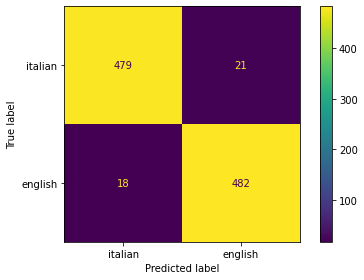

In [143]:
cm = confusion_matrix(y, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=languages)
fig, ax = plt.subplots()
display.plot(ax=ax)
plt.tight_layout()
plt.show()

## Word generation

In [178]:
sql_p3 = """
SELECT T.letter_2, T.counter
FROM italian_3 AS T
WHERE letter_0 = ($prefix0) AND letter_1 = ($prefix1);
"""

sql_p2 = """
SELECT T.letter_1, T.counter
FROM italian_3 AS T
WHERE letter_0 = ($prefix0);
"""


def get_counts(language, n, prefix_list):
    table = "{}_{}".format(language, n)
    if n == 2:
        sql = sql_p2
    else:
        sql = sql_p3
    params = {}
    for i, pr in enumerate(prefix_list):
        params['prefix{}'.format(i)] = "{}".format(pr)
    res = pd.read_sql_query(sql, engine, params=params, index_col='letter_{}'.format(n-1))
    return res / res.sum()

In [187]:
def generate(language='italian', start=['#']):
    prefix = start
    for i in range(100):
        if len(prefix) == 0:
            px = '#'
            n = 2
        elif len(prefix) == 1:
            px = prefix
            n = 2
        elif len(prefix) == 2:
            px = prefix
            n = 3
        else:
            px = prefix[-2:]
            n = 3
        counts = get_counts(language, n, px)
        alphabet, probs = counts.index.values, counts.counter.values
        next_c = np.random.choice(alphabet, p=probs)
        if next_c == '.':
            break
        else:
            prefix.append(next_c)
    prediction = "".join(prefix).replace('#', '')
    return prediction

In [197]:
for i in range(10):
    print(generate(language='english', start=['#', 'p']))

perso
per
per
per
posse
pose
person
prealla
progessene
percasi


'a'